# Section B

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import struct
from array import array
import os
import dill
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings("ignore")

##### 1. Implement a class named NeuralNetwork.

References:

- [Github: Neural Network from Scratch 1](https://github.com/lionelmessi6410/Neural-Networks-from-Scratch/blob/main/NN-from-Scratch.ipynb)

- [Github: Neural Network from Scratch 2](https://github.com/divyajeettt/CSE343/blob/main/Assignment-3/utils.py#L130)

- [Github: Neural Network from Scratch 3](https://github.com/arnav10goel/CSE343-ML-Assignments/blob/main/2021519_HW3/Section%20B/MyNeuralNetwork.ipynb)

In [ ]:
class NeuralNetwork:
    def __init__(self, N, layers, lr, activation, weight_init, epochs, batch_size):
        self.N = N 
        self.layers = layers
        self.lr = lr
        self.activation_layer = activation
        self.activation = self.activate(activation)
        self.weight_init = weight_init
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights, self.biases = self.initialize_weights()
        self.train_loss = []
        self.val_loss = []

    def initialize_weights(self):
        weights = []
        biases = []
        for i in range(1, len(self.layers)):
            weight_shape = (self.layers[i - 1], self.layers[i])
            bias_shape = (1, self.layers[i])
            if self.weight_init == 'zero':
                w = np.zeros(weight_shape)
            elif self.weight_init == 'random':
                _w = np.random.random(weight_shape) * 2 - 1
                w = (_w) / np.sqrt(np.sum(_w**2))
            elif self.weight_init == 'normal':
                _w = np.random.normal(0, 1, weight_shape)
                w = _w / np.sqrt(np.sum(_w ** 2))
            b = np.zeros(bias_shape)
            weights.append(w)
            biases.append(b)
        return weights, biases
    
    def activate(self, x):
        if x == 'sigmoid':
            return lambda z: 1 / (1 + np.exp(-z))
        elif x == 'tanh':
            return lambda z: np.tanh(z)
        elif x == 'relu':
            return lambda z: np.maximum(0, z)
        elif x == 'leaky_relu':
            return lambda z: np.where(z > 0, z, 0.01 * z)

    def gradient(self, z):
        if self.activation_layer == 'sigmoid':
            _z = self.activation(z)
            return _z * (1 - _z)
        elif self.activation_layer == 'tanh':
            return 1 - np.tanh(z) ** 2
        elif self.activation_layer == 'relu':
            return np.where(z > 0, 1, 0)
        elif self.activation_layer == 'leaky_relu':
            return np.where(z > 0, 1, 0.01)
    
    def softmax(self, z):
        exps = np.exp(z - z.max(axis=1, keepdims=True)) 
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        activations = [X]
        for i in range(self.N - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == self.N - 2:
                _activation = self.softmax(z)
            else:
                _activation = self.activation(z)
            activations.append(_activation)
        return activations

    def backward(self, X, Y, activations):
        error = (activations[-1] - Y) / X.shape[0]
        for i in range(self.N - 2, -1, -1):
            d_weights = np.dot(activations[i].T, error)
            d_biases = np.sum(error, axis=0, keepdims=True)
            self.weights[i] -= self.lr * d_weights
            self.biases[i] -= self.lr * d_biases
            error = np.dot(error, self.weights[i].T) * self.gradient(activations[i])
        return error

    
    def calculate_loss(self,y_true, y_pred):
        epsilon = 1e-9
        loss = -np.mean(y_true * np.log(y_pred + epsilon))
        return loss
    
    def fit(self, X_train, y_train, X_val, y_val, patience = 5):
        self.train_loss = []
        self.val_loss = []
        # Early stopping initialization
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        counter = 0
        for epoch in range(self.epochs):
            for i in range(0, X_train.shape[0], self.batch_size):
                X_batch = X_train[i:min(i+self.batch_size, X_train.shape[0])]
                Y_batch = y_train[i:min(i+self.batch_size, X_train.shape[0])]
                activations = self.forward(X_batch)
                err = self.backward(X_batch, Y_batch, activations)
                
            y_train_pred = self.forward(X_train)
            train_loss = self.calculate_loss(y_train, y_train_pred[-1])
            self.train_loss.append(train_loss)
            
            # Validation loss
            y_pred_val = self.forward(X_val)
            val_loss = self.calculate_loss(y_val, y_pred_val[-1])
            self.val_loss.append(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = self.weights.copy()
                best_bias = self.biases.copy()
                counter = 0
            else:
                counter += 1
            if epoch % 25 == 0:
                print(f"Epoch {epoch}: Training Loss = {train_loss}, Validation Loss = {val_loss}")
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}. Training Loss = {train_loss}, Validation Loss = {best_val_loss}")
                break
            if best_weights is not None:
                self.weights = best_weights
                self.biases = best_bias
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        class_indices = y_pred_proba.argmax(axis=1)
        y_pred = np.eye(y_pred_proba.shape[1])[class_indices]
        return y_pred
    
    def predict_proba(self, X):
        activations = self.forward(X)
        return activations[-1]
    
    def score(self, X, Y):
        predictions = self.predict(X)
        return np.mean(predictions == Y)
    
    def plot_metrics(self):
        plt.plot(self.train_loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

Reference:

- [Kaggle: Reading MNIST Dataset](https://www.kaggle.com/code/hojjatk/read-mnist-dataset)

In [3]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

In [4]:
training_images_filepath = './dataset/train-images.idx3-ubyte'
training_labels_filepath = './dataset/train-labels.idx1-ubyte'
test_images_filepath = './dataset/t10k-images.idx3-ubyte'
test_labels_filepath = './dataset/t10k-labels.idx1-ubyte'

In [5]:
mnist = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)

In [6]:
(X_train_init, y_train_init), (X_test_init, y_test_init) = mnist.load_data()

In [7]:
# Combining to get a complete dataset
X = np.concatenate([X_train_init, X_test_init])
y = np.concatenate([y_train_init, y_test_init])

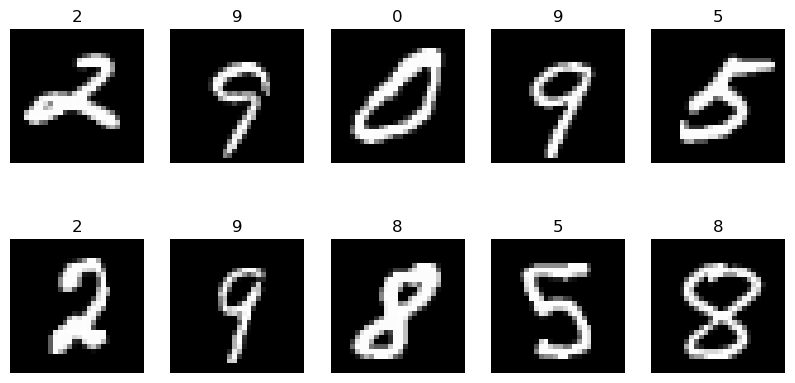

In [109]:
plt.figure(figsize=(10, 5))

indices = np.random.randint(0, X.shape[0], 10)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[indices[i]].reshape(28, 28), cmap="gray")
    plt.title(y[indices[i]])
    plt.axis("off")

plt.show()

In [8]:
# Splitting the dataset into 80:10:10 (train: test: validation)
# First split : 80% into training and 20% into validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 50% of temp data for test, 50% for validation (10% of total data each)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the sizes of each set
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (56000, 28, 28)
Testing set size: (7000, 28, 28)
Validation set size: (7000, 28, 28)


In [9]:
# One hot encoding
def to_one_hot(Y, num_classes = 10):
    return np.eye(num_classes)[Y]

In [10]:
# Reshaping to flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

# Normalizing the data
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

# One hot encoding the target variables
y_train = to_one_hot(y_train)
y_val = to_one_hot(y_val)
y_test = to_one_hot(y_test)

In [11]:
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (56000, 784) (56000, 10)
Validation set: (7000, 784) (7000, 10)
Test set: (7000, 784) (7000, 10)


In [13]:
# Using dill to save and load the model because it can serialize lambda functions
def save_model(model, filename):
    file_path = os.path.join('models', filename)
    with open(file_path, 'wb') as file:
        dill.dump(model, file)

def load_model(filename):
    file_path = os.path.join('models', filename)
    with open(file_path, 'rb') as file:
        return dill.load(file)

In [116]:
hidden_layers = 4
n = 6
layers = [784, 256, 128, 64, 32, 10]
epochs = 100
batch_size = 64
lr = 0.01

### Activation Layer: Sigmoid

##### Weight initialization function: Zero_init

In [121]:
model1 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='sigmoid', weight_init='zero', epochs=epochs, batch_size=batch_size)

In [122]:
model1.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23013827151286287, Validation Loss = 0.230082261091486
Early stopping at epoch 5. Training Loss = 0.23013842637780252, Validation Loss = 0.230082261091486


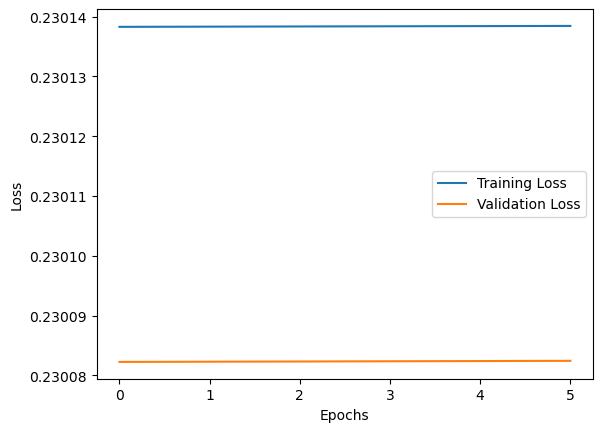

In [123]:
model1.plot_metrics()

In [124]:
accuracy = model1.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [125]:
save_model(model1, 'sigmoid_zero_model.pkl')


In [ ]:
# model1 = load_model('sigmoid_zero_model.pkl')
# accuracy = model1.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

##### Weight initialization function: Random_init

In [126]:
model2 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='sigmoid', weight_init='random', epochs=epochs, batch_size=batch_size)

In [127]:
model2.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23013881481287846, Validation Loss = 0.23008301144699222
Early stopping at epoch 5. Training Loss = 0.23013898423364748, Validation Loss = 0.23008301144699222


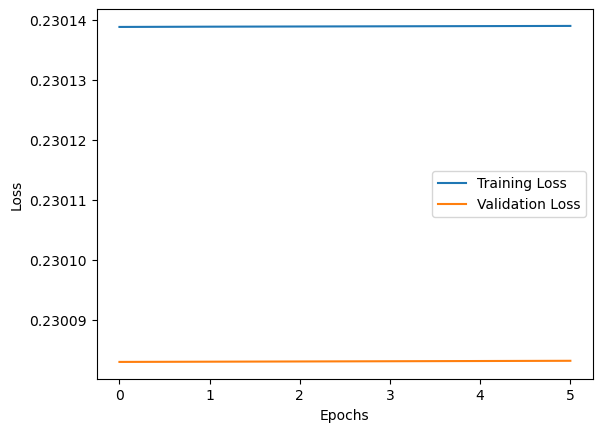

In [128]:
model2.plot_metrics()

In [129]:
accuracy = model2.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [130]:
save_model(model2, 'sigmoid_random_model.pkl')

In [ ]:
# model2 = load_model('sigmoid_random_model.pkl')
# accuracy = model2.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


##### Weight initialization function: Normal_init

In [131]:
model3 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='sigmoid', weight_init='normal', epochs=epochs, batch_size=batch_size)

In [132]:
model3.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.2301382035023343, Validation Loss = 0.23008206058062702
Early stopping at epoch 6. Training Loss = 0.23013834712461106, Validation Loss = 0.23008203303265737


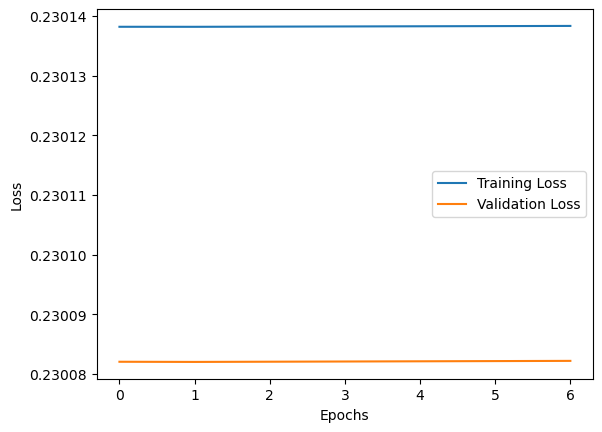

In [133]:
model3.plot_metrics()

In [134]:
accuracy = model3.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [135]:
save_model(model3, 'sigmoid_normal_model.pkl')

In [ ]:
# model3 = load_model('sigmoid_normal_model.pkl')
# accuracy = model3.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

### Activation Layer: tanh

##### Weight initialization function: Zero_init

In [136]:
model4 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='tanh', weight_init='zero', epochs=epochs, batch_size=batch_size)

In [137]:
model4.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23014469700211107, Validation Loss = 0.23010955130127542
Early stopping at epoch 18. Training Loss = 0.23012258384269943, Validation Loss = 0.23006526247578082


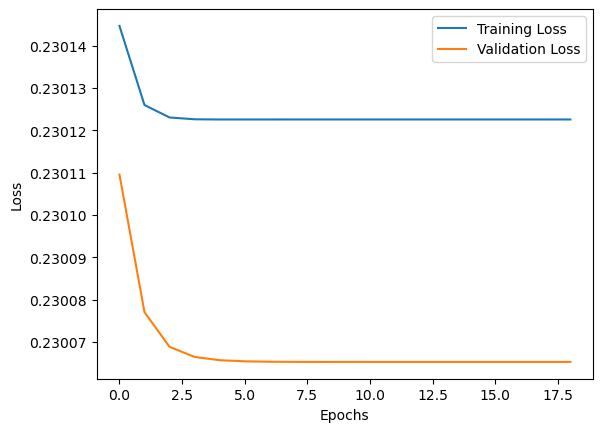

In [138]:
model4.plot_metrics()

In [139]:
accuracy = model4.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [140]:
save_model(model4, 'tanh_zero_model.pkl')

In [ ]:
# model4 = load_model('tanh_zero_model.pkl')
# accuracy = model4.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

##### Weight initialization function: Random_init

In [141]:
model5 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='tanh', weight_init='random', epochs=epochs, batch_size=batch_size)

In [142]:
model5.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.2301402847687143, Validation Loss = 0.2301025120704569
Epoch 25: Training Loss = 0.22998707111529956, Validation Loss = 0.22992956219036773
Epoch 50: Training Loss = 0.028385059270776655, Validation Loss = 0.03036991566280574
Epoch 75: Training Loss = 0.010037939345778823, Validation Loss = 0.016283017885309305
Early stopping at epoch 91. Training Loss = 0.00699736103302706, Validation Loss = 0.015766905071649556


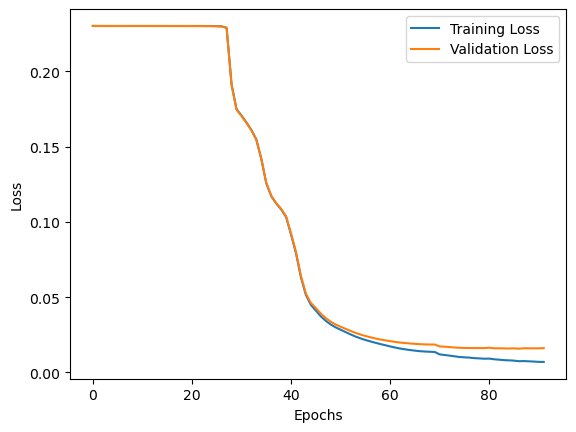

In [143]:
model5.plot_metrics()

In [144]:
accuracy = model5.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 99.10 %


In [145]:
save_model(model5, 'tanh_random_model.pkl')

In [16]:
# model5 = load_model('tanh_random_model.pkl')
# accuracy = model5.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

##### Weight initialization function: Normal_init

In [147]:
model6 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='tanh', weight_init='normal', epochs=epochs, batch_size=batch_size)

In [148]:
model6.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23014056157865145, Validation Loss = 0.23010431586608565
Epoch 25: Training Loss = 0.23009753077136028, Validation Loss = 0.23004020309905446
Epoch 50: Training Loss = 0.05268688818080332, Validation Loss = 0.052544262570256774
Early stopping at epoch 74. Training Loss = 0.015978561782440278, Validation Loss = 0.020891179553392092


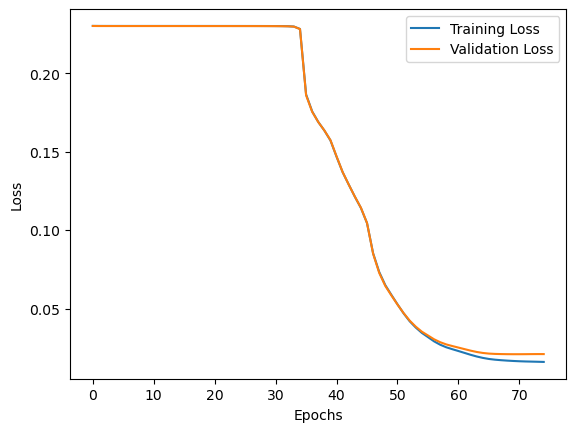

In [149]:
model6.plot_metrics()

In [150]:
accuracy = model6.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 98.80 %


In [151]:
save_model(model6, 'tanh_normal_model.pkl')

In [53]:
# model6 = load_model('tanh_normal_model.pkl')
# accuracy = model6.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

### Activation Layer: Relu

##### Weight initialization function: Zero_init

In [152]:
model7 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='relu', weight_init='zero', epochs=epochs, batch_size=batch_size)

In [153]:
model7.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23014469700211107, Validation Loss = 0.23010955130127542
Early stopping at epoch 18. Training Loss = 0.23012258384269943, Validation Loss = 0.23006526247578082


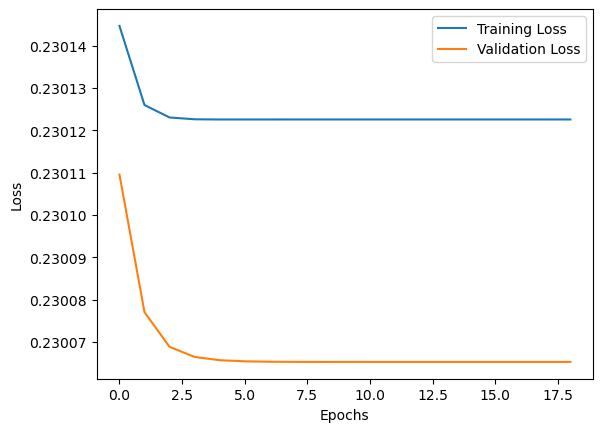

In [154]:
model7.plot_metrics()

In [155]:
accuracy = model7.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [156]:
save_model(model7, 'relu_zero_model.pkl')

In [ ]:
# model7 = load_model('relu_zero_model.pkl')
# accuracy = model7.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

##### Weight initialization function: Random_init

In [157]:
model8 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='relu', weight_init='random', epochs=epochs, batch_size=batch_size)

In [158]:
model8.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23014460668853892, Validation Loss = 0.23010923730495217
Epoch 25: Training Loss = 0.2301224354762702, Validation Loss = 0.23006519738524367
Epoch 50: Training Loss = 0.2301221157651398, Validation Loss = 0.23006484568426444
Epoch 75: Training Loss = 0.2301206699521478, Validation Loss = 0.23006342203728825


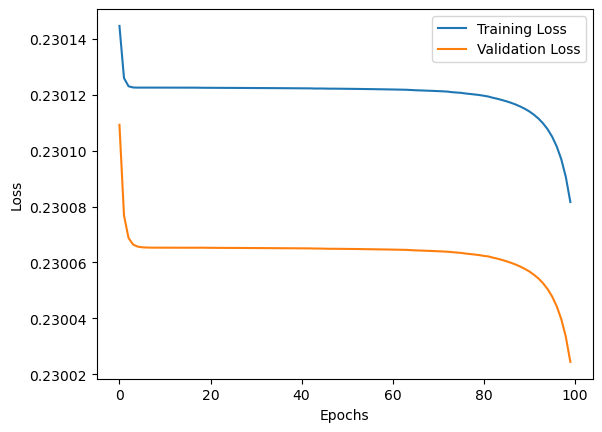

In [159]:
model8.plot_metrics()

In [160]:
accuracy = model8.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [161]:
save_model(model8, 'relu_random_model.pkl')

In [ ]:
# model8 = load_model('relu_random_model.pkl')
# accuracy = model8.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

##### Weight initialization function: Normal_init

In [162]:
model9 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='relu', weight_init='normal', epochs=epochs, batch_size=batch_size)

In [163]:
model9.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.2301443605450331, Validation Loss = 0.2301091584476786
Epoch 25: Training Loss = 0.23012252979687117, Validation Loss = 0.2300652085911692
Epoch 50: Training Loss = 0.23012248100201935, Validation Loss = 0.2300651596440725
Epoch 75: Training Loss = 0.2301224062919049, Validation Loss = 0.23006508468145437


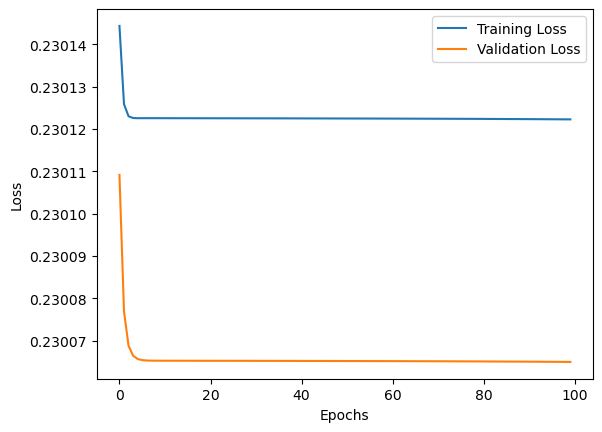

In [164]:
model9.plot_metrics()

In [165]:
accuracy = model9.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [166]:
save_model(model9, 'relu_normal_model.pkl')

In [185]:
# model9 = load_model('relu_normal_model.pkl')
# accuracy = model9.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

### Activation Layer: Leaky_relu

##### Weight initialization function: Zero_init

In [167]:
model10 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='leaky_relu', weight_init='zero', epochs=epochs, batch_size=batch_size)

In [168]:
model10.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23014469700211107, Validation Loss = 0.23010955130127542
Early stopping at epoch 18. Training Loss = 0.23012258384269943, Validation Loss = 0.23006526247578082


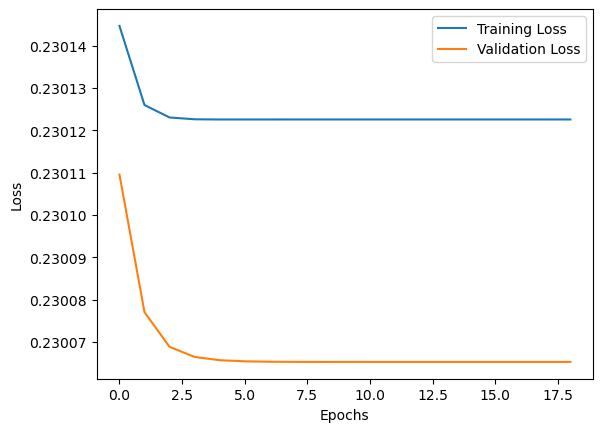

In [169]:
model10.plot_metrics()

In [170]:
accuracy = model10.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 82.23 %


In [171]:
save_model(model10, 'leaky_relu_zero_model.pkl')

In [ ]:
# model10 = load_model('leaky_relu_zero_model.pkl')
# accuracy = model10.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

##### Weight initialization function: Random_init

In [172]:
model11 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='leaky_relu', weight_init='random', epochs=epochs, batch_size=batch_size)

In [173]:
model11.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23014383593862736, Validation Loss = 0.23010866177341194
Epoch 25: Training Loss = 0.23012211967130208, Validation Loss = 0.23006480234829527
Epoch 50: Training Loss = 0.23012104628864083, Validation Loss = 0.23006368646537548
Epoch 75: Training Loss = 0.23011004545306465, Validation Loss = 0.2300523281762282
Early stopping at epoch 96. Training Loss = nan, Validation Loss = 0.14195808927392226


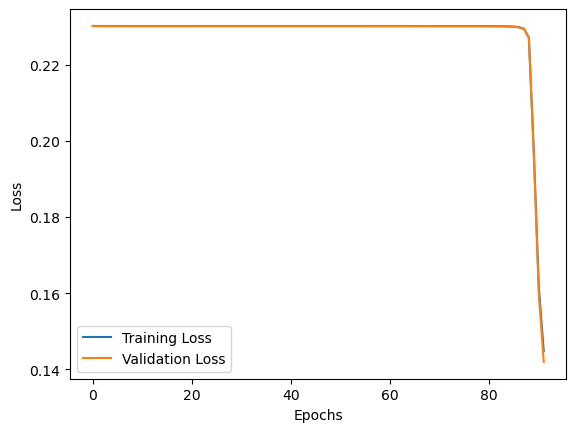

In [174]:
model11.plot_metrics()

In [175]:
accuracy = model11.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 81.88 %


In [176]:
save_model(model11, 'leaky_relu_random_model.pkl')

In [ ]:
# model11 = load_model('leaky_relu_random_model.pkl')
# accuracy = model11.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

##### Weight initialization function: Normal_init

In [177]:
model12 = NeuralNetwork(N=n, layers=layers, lr=lr, activation='leaky_relu', weight_init='normal', epochs=epochs, batch_size=batch_size)

In [178]:
model12.fit(X_train, y_train, X_val, y_val)

Epoch 0: Training Loss = 0.23014337903852147, Validation Loss = 0.23010702641162278
Epoch 25: Training Loss = 0.23012128453529437, Validation Loss = 0.2300639152499123
Epoch 50: Training Loss = 0.23011290737629106, Validation Loss = 0.23005526002116916
Early stopping at epoch 74. Training Loss = nan, Validation Loss = 0.1470703828135586


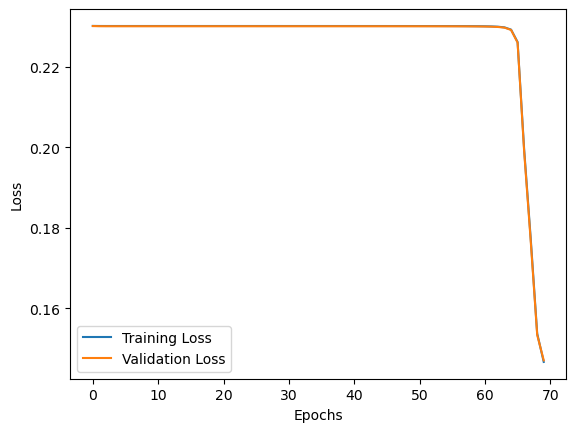

In [179]:
model12.plot_metrics()

In [180]:
accuracy = model12.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 81.88 %


In [181]:
save_model(model12, 'leaky_relu_normal_model.pkl')

In [183]:
# model12 = load_model('leaky_relu_normal_model.pkl')
# accuracy = model12.score(X_test, y_test)
# print(f"Accuracy: {accuracy * 100:.2f} %")

Findings:
- `tanh` with `random_init` initialization function performs the best with 99.1 % accuracy.
- For other activation layers except `tanh`, all models have comparable performance with accuracy around 81-82 %.
- 10 out of 12 models stopped before completing 100 epochs due to early stopping due to overfitting.